# Introduction
Welcome to the "M5 Forecasting - Accuracy" competition! In this competition, contestants are challenged to forecast future sales at Walmart based on heirarchical sales in the states of California, Texas, and Wisconsin.

# Task in hand
In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the test set.

The rows  [d_1914 - d_1941] form the validation set.

Remaining rows form the training set.

# Appeal to fellow Kagglers:)
This is my first attempt towards a time series problem, so, please upvote this kernel,your upvote will be like a reward for my work.

# This notebook will cover only EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm
import statsmodels.api as sm
import gc
plt.style.use('fivethirtyeight')
from pylab import rcParams
import random
import seaborn as sns
from lightgbm import LGBMRegressor


In [2]:
# to display all the columns in the dataset
pd.pandas.set_option('display.max_columns', None)

# Lets check the datasets

In [3]:
train_sales = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_evaluation.csv")
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
sell_prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv")

In [4]:
train_sales.shape, calendar.shape,sell_prices.shape

((30490, 1947), (1969, 14), (6841121, 4))

In [5]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [7]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [8]:
train_sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


There are lots of zeros in the datasets for "d_x" columns, these are nothing bul sale values on any given day, zero here signfies, either the item was not available on that day or was not sold because of no demand.

In [9]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Lets check for null values

In [11]:
train_sales.isnull().sum().sort_values(ascending = False)

d_1941    0
d_663     0
d_635     0
d_636     0
d_637     0
         ..
d_1297    0
d_1298    0
d_1299    0
d_1300    0
id        0
Length: 1947, dtype: int64

In [12]:
sell_prices.isnull().sum().sort_values(ascending = False)

sell_price    0
wm_yr_wk      0
item_id       0
store_id      0
dtype: int64

In [13]:
calendar.isnull().sum().sort_values(ascending = False)

event_type_2    1964
event_name_2    1964
event_type_1    1807
event_name_1    1807
snap_WI            0
snap_TX            0
snap_CA            0
d                  0
year               0
month              0
wday               0
weekday            0
wm_yr_wk           0
date               0
dtype: int64

# Memory Reduction

We have a huge dataset to work on, and before feeding this dataset into the model, we are going to "Melt" it which would the data fram would be converted from wide format to a long format. I have kept the id variables as id, item_id, dept_id, cat_id, store_id and state_id. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1969 days. Therefore the melted dataframe will be having 30490x1969 i.e. 60034810 rows.

In order to process to such huge dataset, we would need to reduce the memor usage. 

In [14]:
# memory usage reduction
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [15]:
# calling memory reduction function for each data set
train_sales = downcast(train_sales)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

# Exploratory Data Analysis

In [16]:
# let's save the list of date variables to a list
d_cols = [c for c in train_sales.columns if 'd_' in c]

In [17]:
# lets save top 3 selling items to be analysed later
top3 = train_sales.set_index("id")[d_cols].sum(1).sort_values(ascending  = False)[:3].index

# Melting the dataframe

In [18]:
grid_df = pd.melt(train_sales, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales")

In [19]:
group = grid_df.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['sales'].sum().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'sales'},inplace=True)
fig = px.treemap(group, path=['USA','State', 'Store', 'Category', 'Department'], values='sales',
                  color='sales',
                  title='Sum of sales across whole USA/different States/Stores/Categories/Departments')
fig.update_layout(template='seaborn')
fig.show()

In [20]:
del train_sales
gc.collect()

11664

In [21]:
# lets drop the columns we are not going to use for EDA
calendar.drop(['wm_yr_wk','weekday','wday','month','year','event_name_1','event_type_1', 'event_name_2','event_type_2'],1,inplace=True)

# Create a master dataset by merging melted dataset and the calendar dataset

In [22]:
master = pd.merge(grid_df,calendar, on = "d")
master.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,0,0,0


In [23]:
del grid_df
gc.collect()

60

# Helper Functions
    1. sales: To plot graphs for sales of different categories
    2. decompose: This function will decompose the given time series into three parts, "seasonal", "trend" and "observed"
    3. random_color: This function will pick a random color for the graph calling this function.

In [24]:
def sales(feat,param):
    sales_df = master.loc[master[feat] == param]
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df =sales_df.groupby('date')['sales'].sum().reset_index()
    sales_df = sales_df.set_index('date')
    return sales_df

In [25]:
from itertools import cycle, islice
def decompose(y):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()

In [26]:
def random_color():
    colors = ["blue","black","brown","red","yellow","green","orange","turquoise","magenta","cyan"]
    random.shuffle(colors)
    return colors[0]

# STATE WISE SALES

Let's take a look at the state wise sales

We will preprocess our data a little bit before moving forward. Daily data can be tricky to work with since it’s a briefer amount of time, so let’s use monthly averages instead. We’ll make the conversion with the resample function.

In [27]:
# list of unique states
master.state_id.unique()

[CA, TX, WI]
Categories (3, object): [CA, TX, WI]

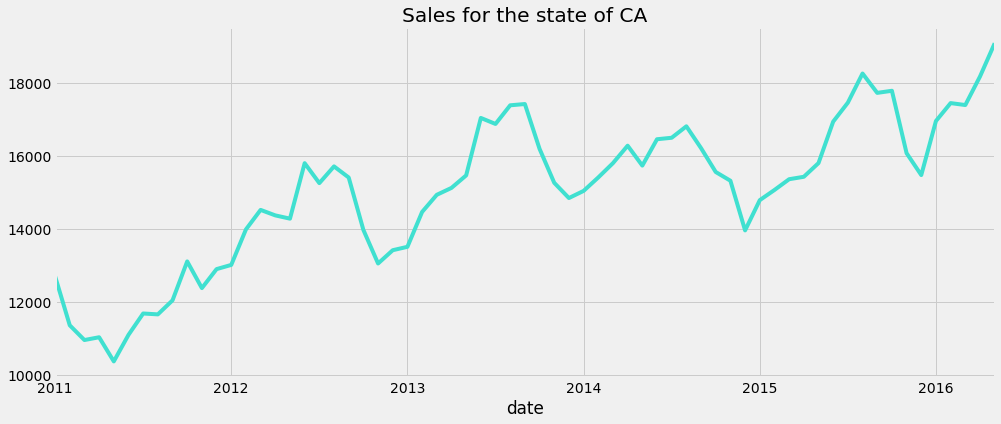

In [28]:
CA = sales("state_id","CA") # create a dataframe for the state CA
y_ca = CA['sales'].resample('MS').mean() # taking monthly average
colour = random_color()
y_ca.plot(figsize=(15, 6),color = colour,title = ("Sales for the state of CA"))
plt.ylabel = ("Sales")
plt.show()

Some distinguishable patterns appear when we plot the data. 
The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the mid of the year. 
There is always an upward trend within any single year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

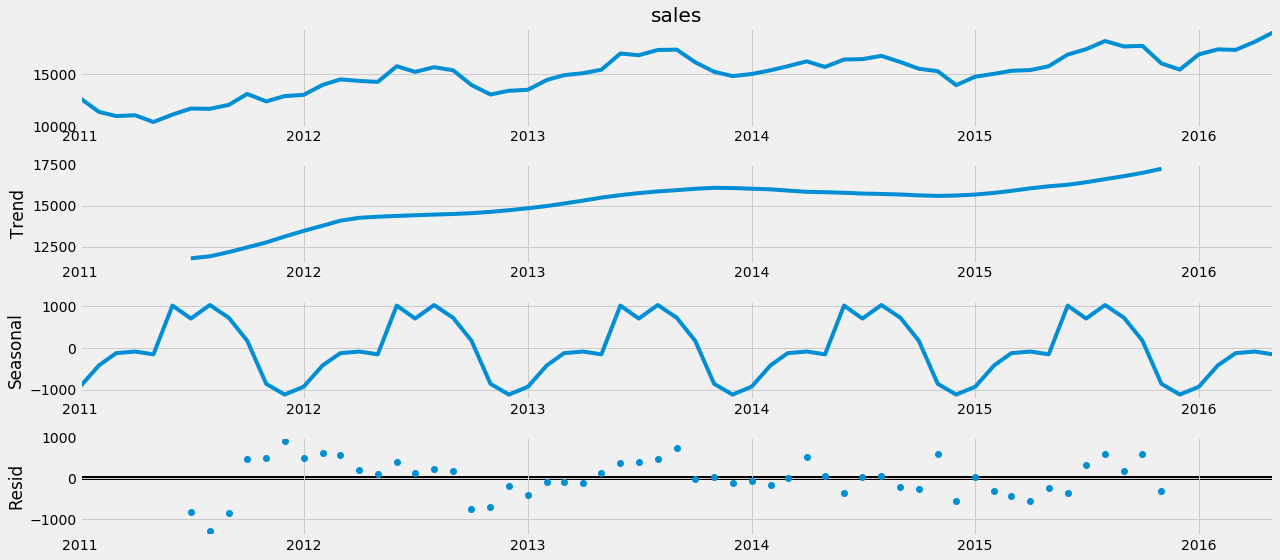

In [29]:
decompose(y_ca)

The plot above clearly shows that the sales of state CA is unstable, along with its obvious seasonality.

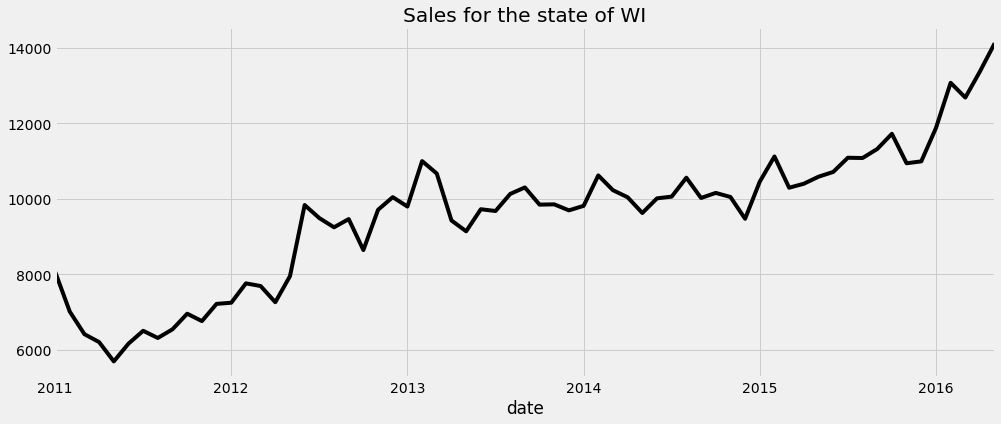

In [30]:
WI = sales("state_id","WI")
y_wi = WI['sales'].resample('MS').mean()
colour = random_color()
y_wi.plot(figsize=(15, 6),color = colour,title = ("Sales for the state of WI"))
plt.ylabel = ("Sales")
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the mid of the year. There is always an upward trend within any single year.

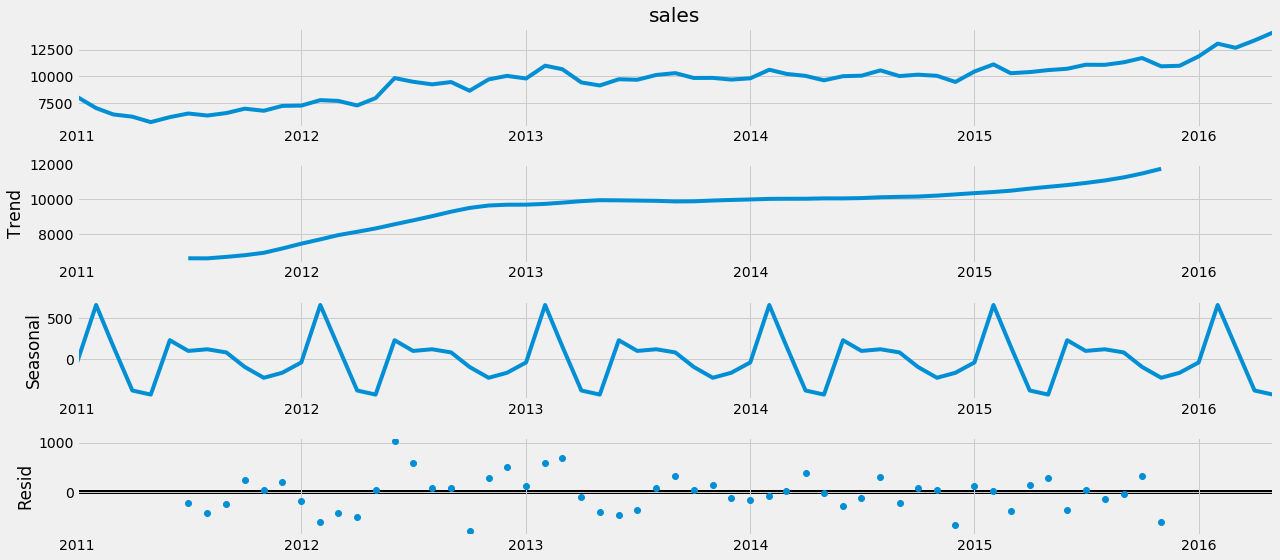

In [31]:
decompose(y_wi)

The plot above clearly shows that the sales of state CA is unstable, along with its obvious seasonality.

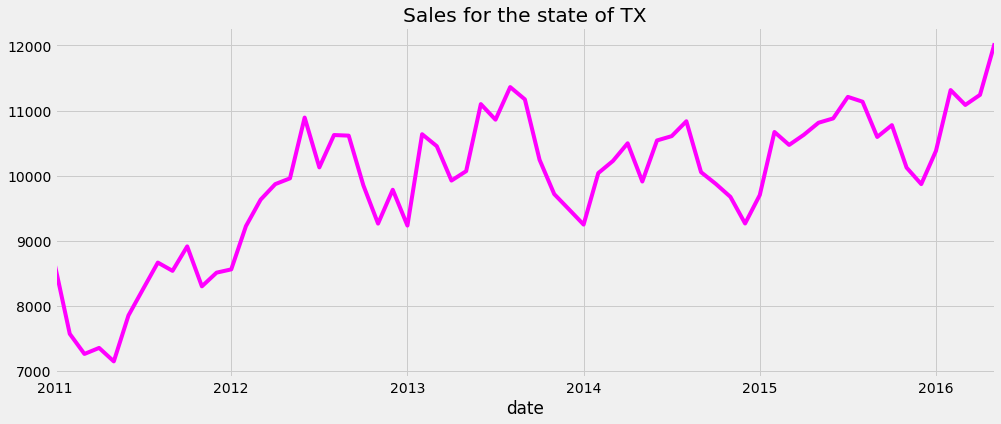

In [32]:
TX = sales("state_id","TX")
y_tx = TX['sales'].resample('MS').mean()
colour = random_color()
y_tx.plot(figsize=(15, 6),color = colour,title = ("Sales for the state of TX"))
plt.show()

Sales are not very different from the other states.

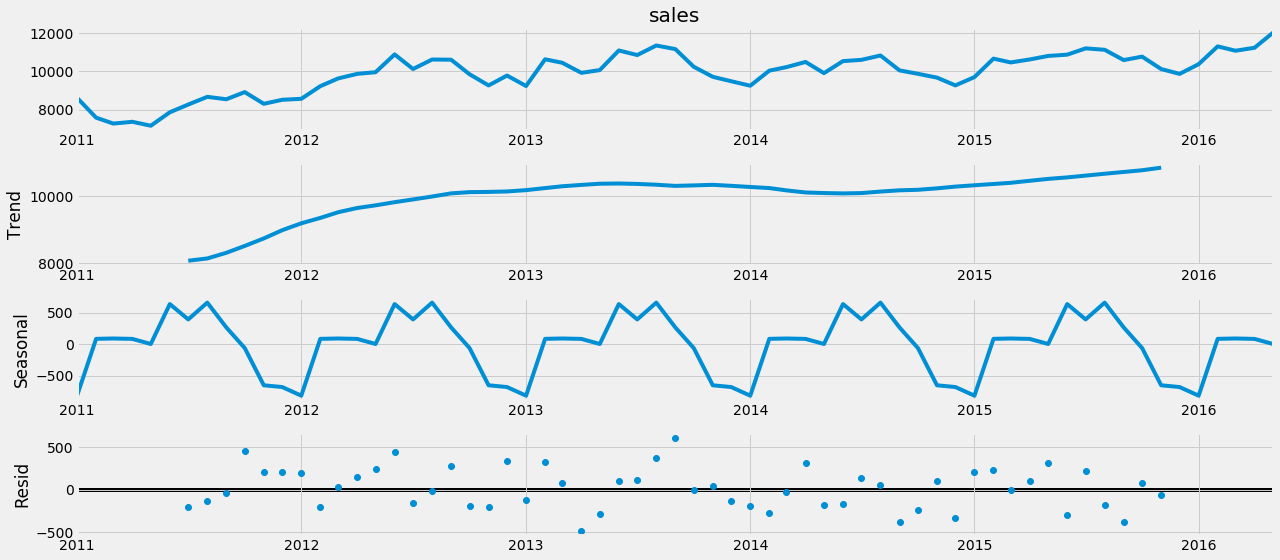

In [33]:
decompose(y_tx)

In [34]:
del CA,WI,TX
gc.collect()

33122

# CATEGORY WISE SALES

Let's take a look at the category wise sales

In [35]:
# list of unique categories
master.cat_id.unique()

[HOBBIES, HOUSEHOLD, FOODS]
Categories (3, object): [HOBBIES, HOUSEHOLD, FOODS]

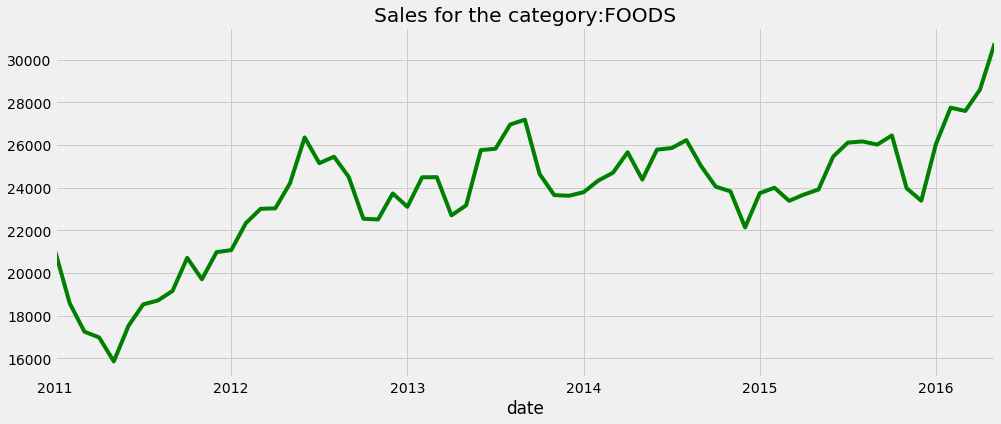

In [36]:
foods = sales("cat_id","FOODS")
y_f = foods['sales'].resample('MS').mean()
colour = random_color()
y_f.plot(figsize=(15, 6),color = colour,title = ("Sales for the category:FOODS"))
plt.show()

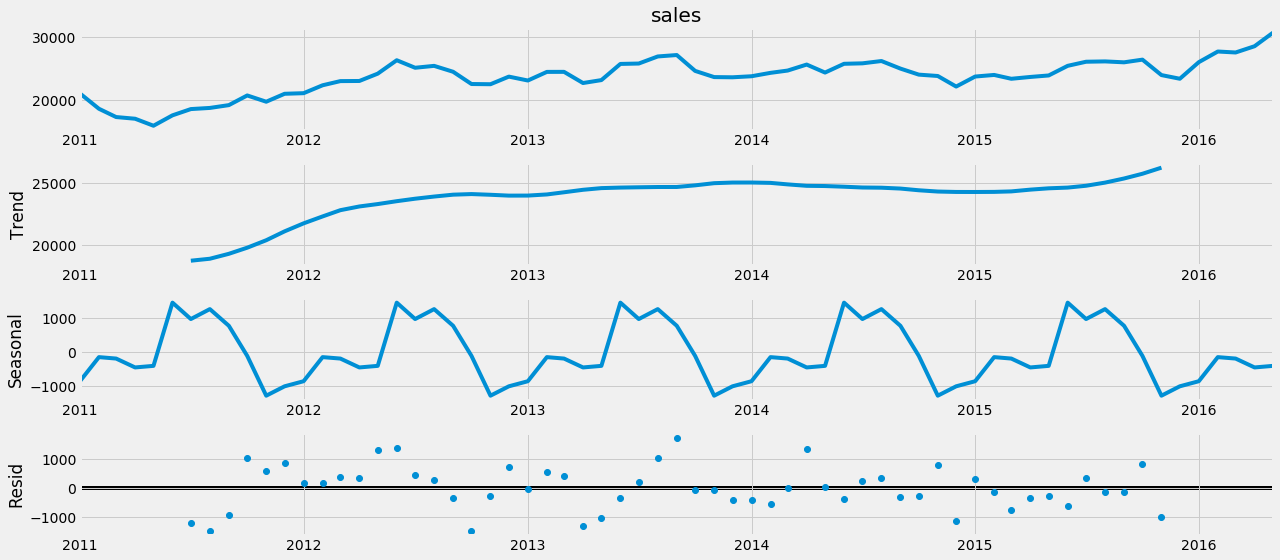

In [37]:
decompose(y_f)

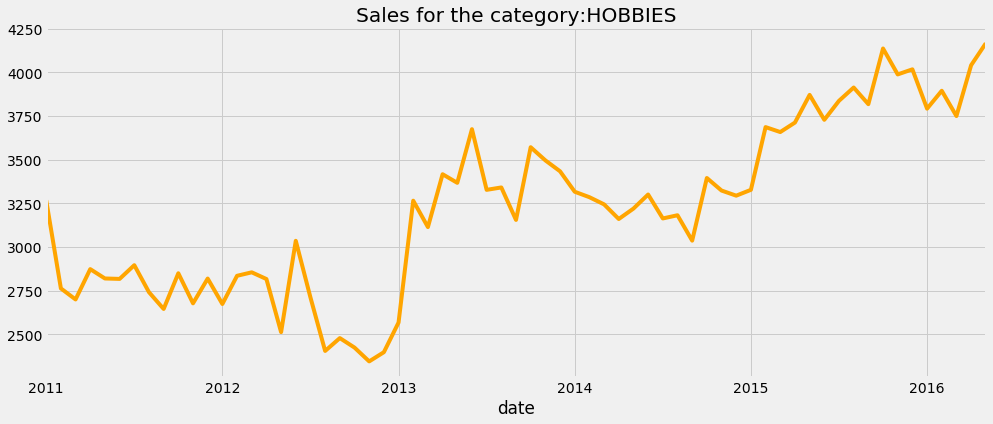

In [38]:
hobbies = sales("cat_id","HOBBIES")
y_hb = hobbies['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_hb.plot(figsize=(15, 6),color = colour,title = ("Sales for the category:HOBBIES"))
plt.show()

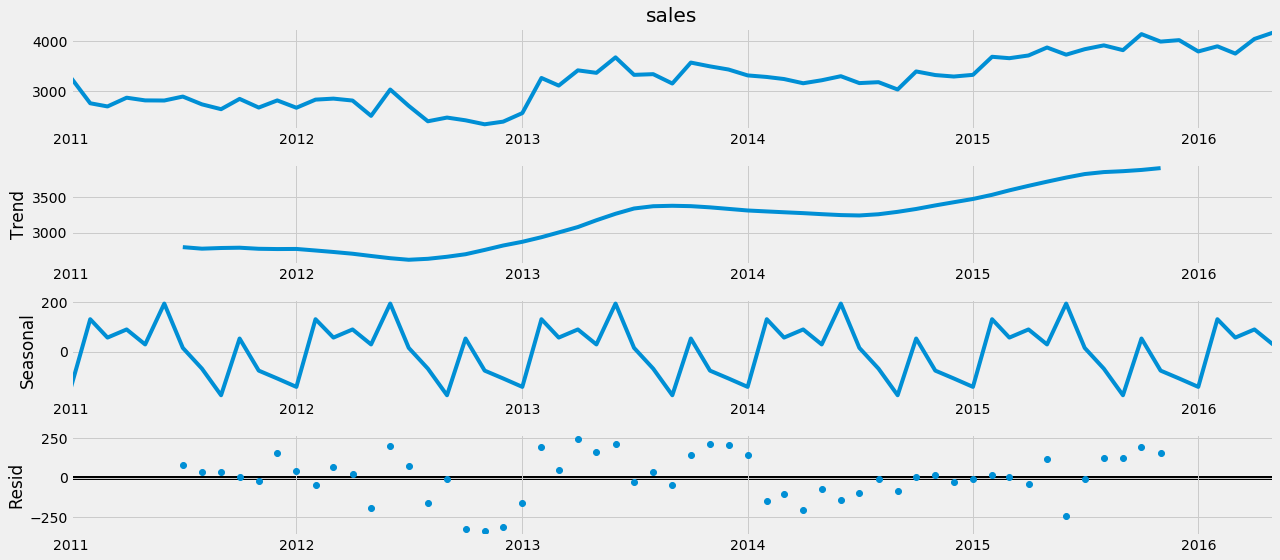

In [39]:
decompose(y_hb)

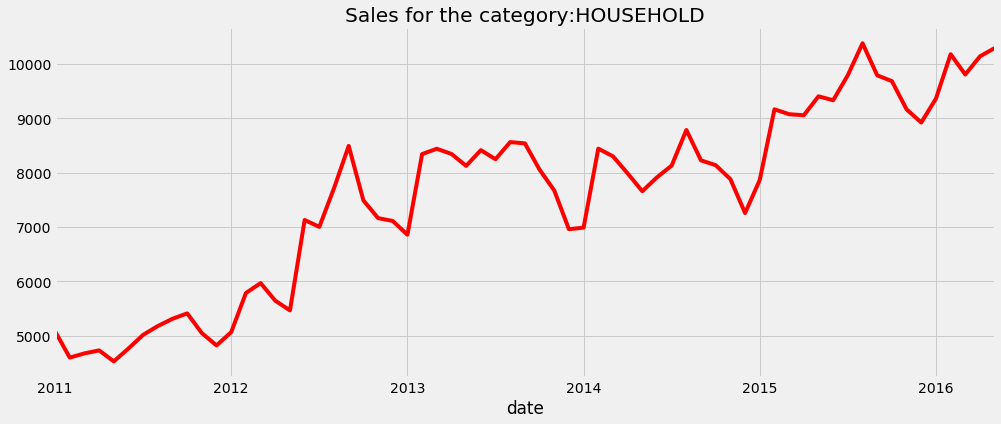

In [40]:
household = sales("cat_id","HOUSEHOLD")
y_hh = household['sales'].resample('MS').mean()
colour = random_color()
y_hh.plot(figsize=(15, 6),color = colour,title = ("Sales for the category:HOUSEHOLD"))
plt.show()

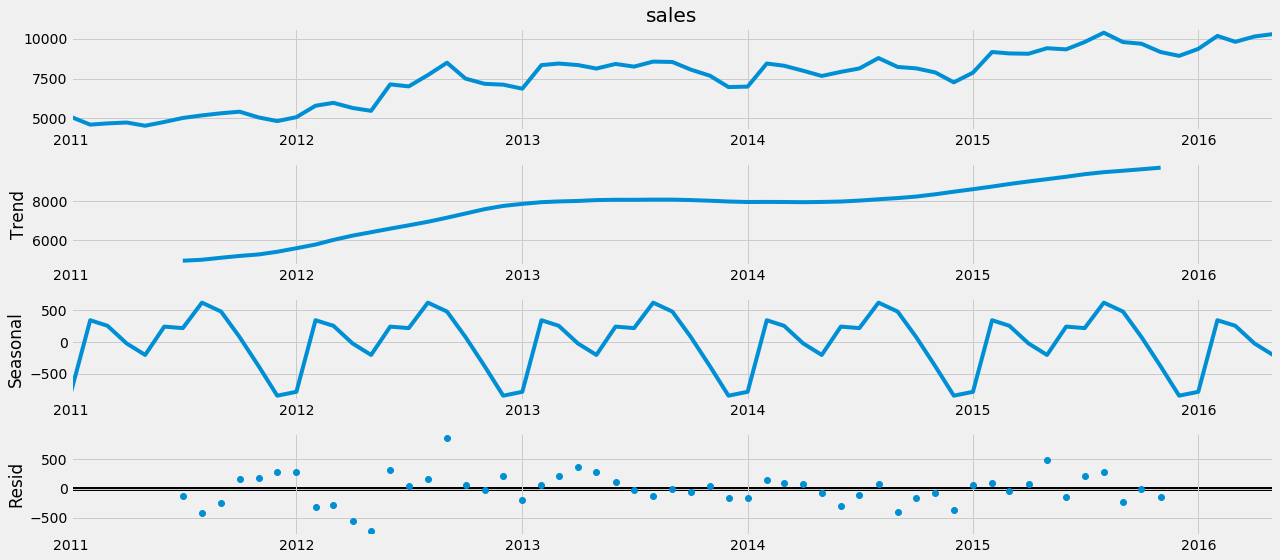

In [41]:
decompose(y_hh)

In [42]:
del foods,hobbies,household,y_f,y_hb,y_hh
gc.collect()

33397

# STORE WISE SALES

In [43]:
master.store_id.unique

<bound method Series.unique of 0           CA_1
1           CA_1
2           CA_1
3           CA_1
4           CA_1
            ... 
59181085    WI_3
59181086    WI_3
59181087    WI_3
59181088    WI_3
59181089    WI_3
Name: store_id, Length: 59181090, dtype: category
Categories (10, object): [CA_1, CA_2, CA_3, CA_4, ..., TX_3, WI_1, WI_2, WI_3]>

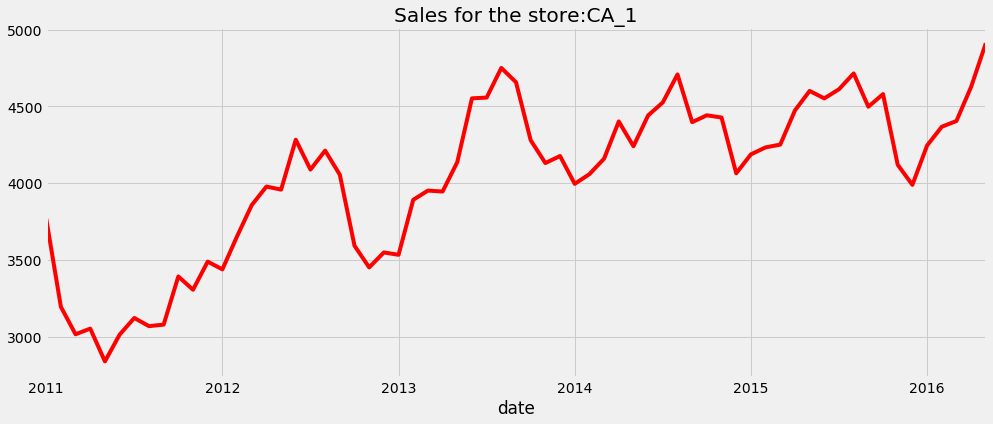

In [44]:
CA_1 = sales("store_id","CA_1")
y_CA1 = CA_1['sales'].resample('MS').mean()
colour = random_color()
y_CA1.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:CA_1"))
plt.show()

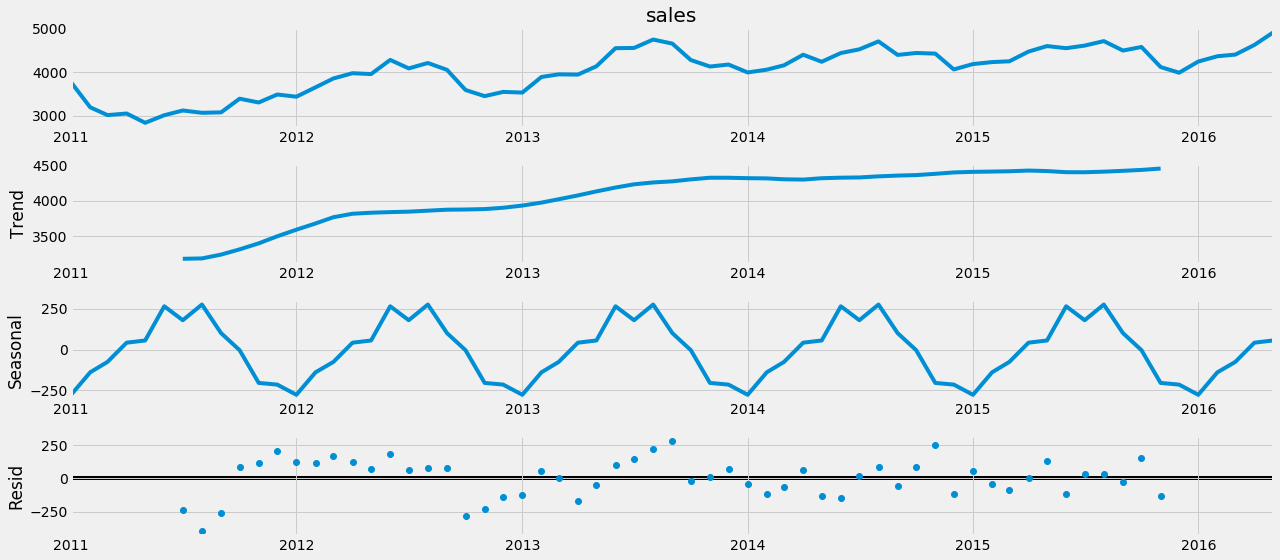

In [45]:
decompose(y_CA1)

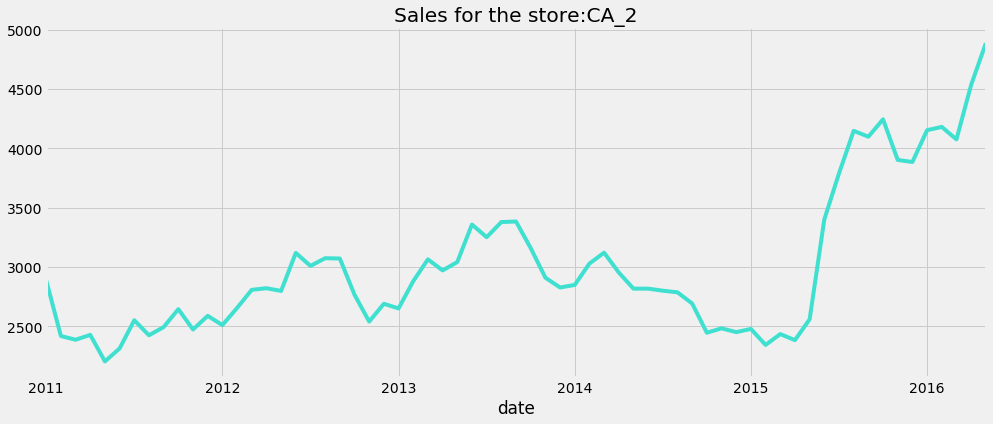

In [46]:
CA_2 = sales("store_id","CA_2")
y_CA2 = CA_2['sales'].resample('MS').mean()
colour = random_color()
y_CA2.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:CA_2"))
plt.show()

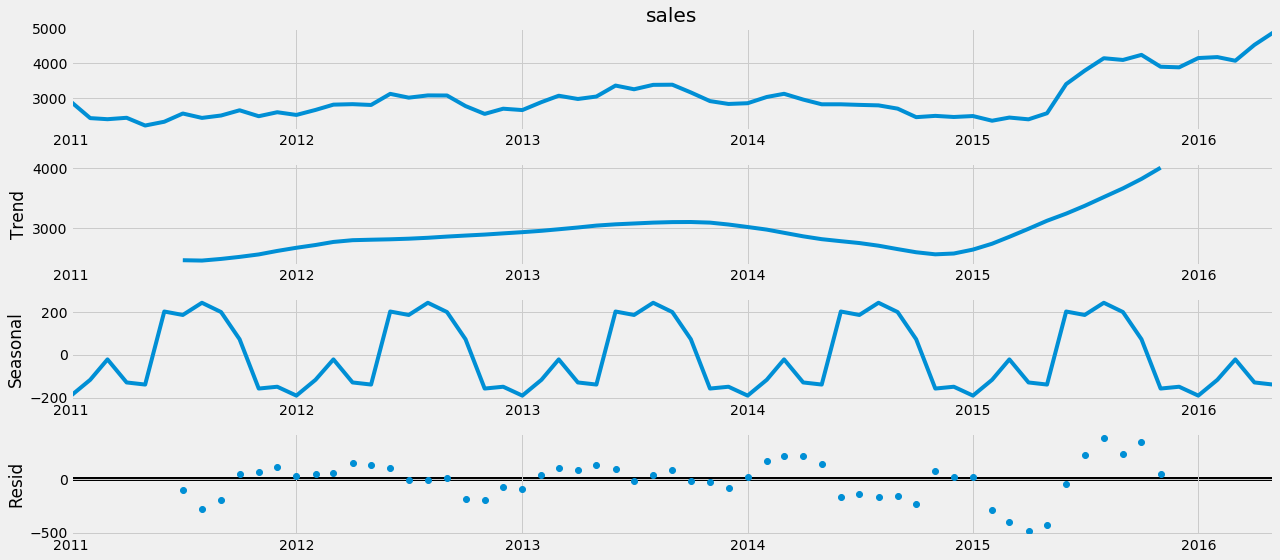

In [47]:
decompose(y_CA2)

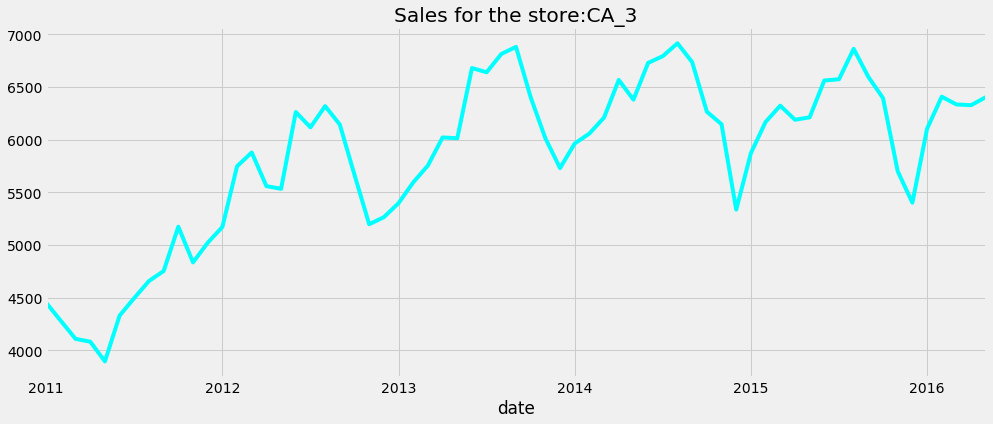

In [48]:
CA_3 = sales("store_id","CA_3")
y_CA3 = CA_3['sales'].resample('MS').mean()
colour = random_color()
y_CA3.plot(figsize=(15, 6),color = colour,title = "Sales for the store:CA_3")
plt.show()

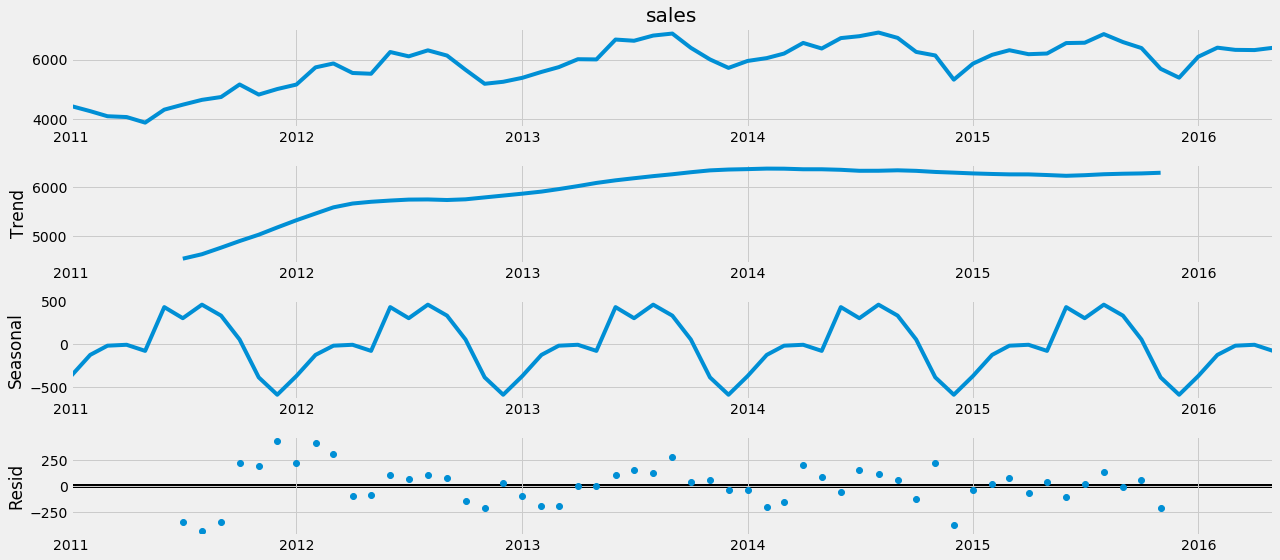

In [49]:
decompose(y_CA3)

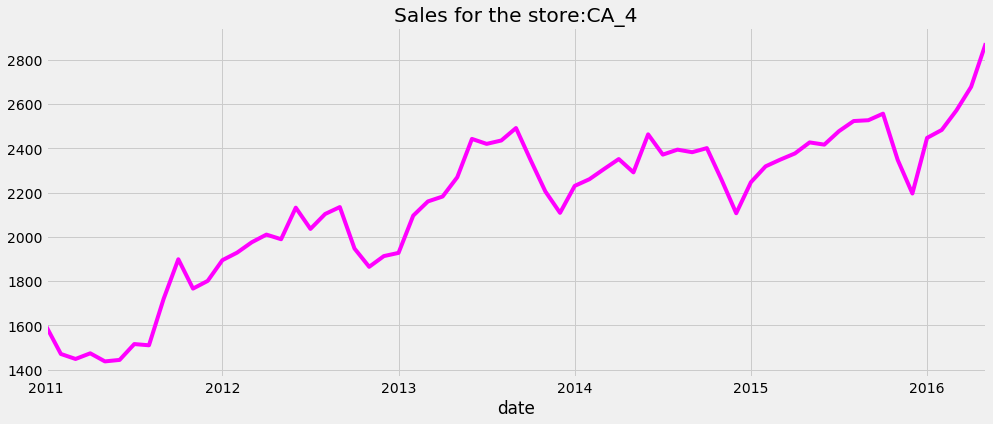

In [50]:
CA_4 = sales("store_id","CA_4")
y_CA4 = CA_4['sales'].resample('MS').mean()
colour = random_color()
y_CA4.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:CA_4"))
plt.show()

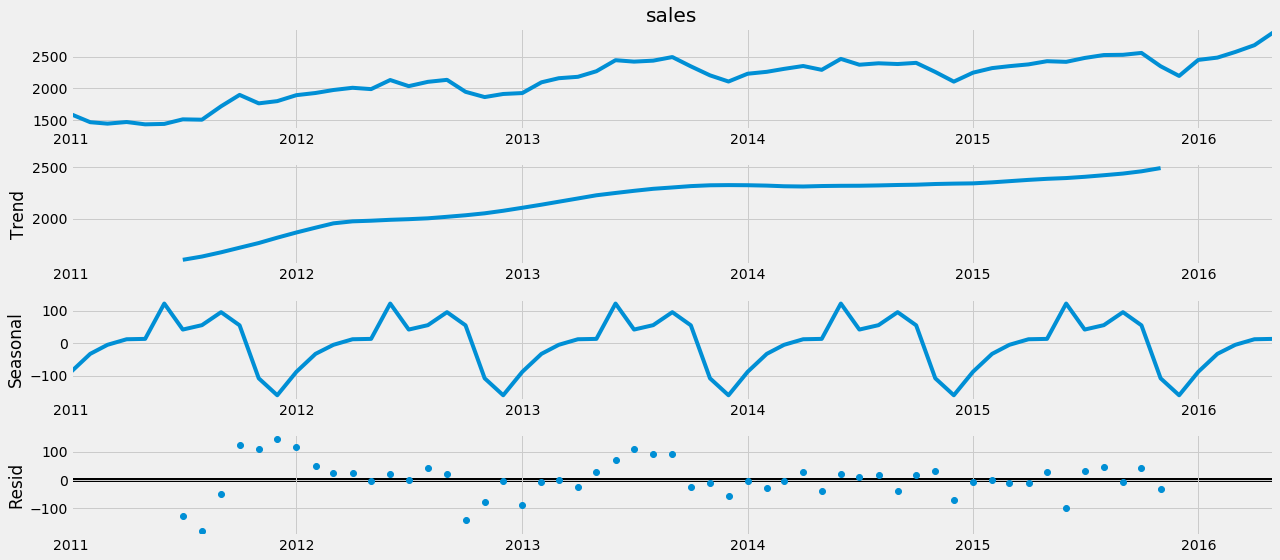

In [51]:
decompose(y_CA4)

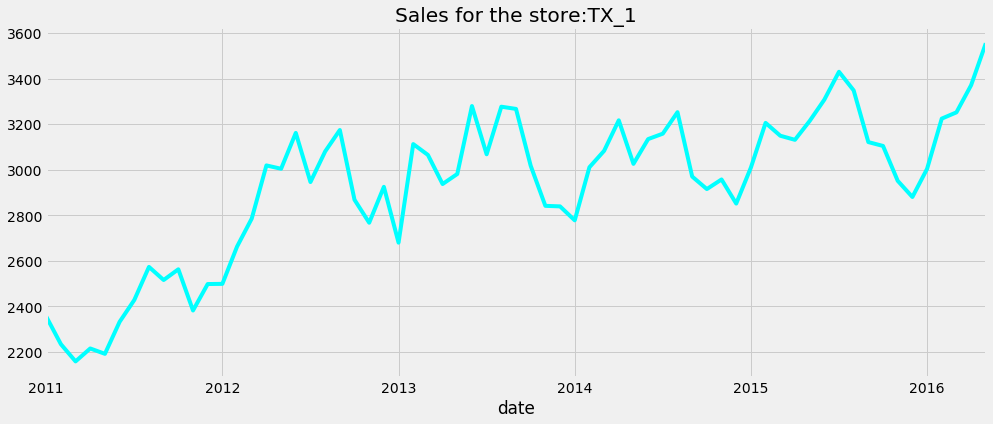

In [52]:
TX_1 = sales("store_id","TX_1")
y_TX1 = TX_1['sales'].resample('MS').mean()
colour = random_color()
y_TX1.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:TX_1"))
plt.show()

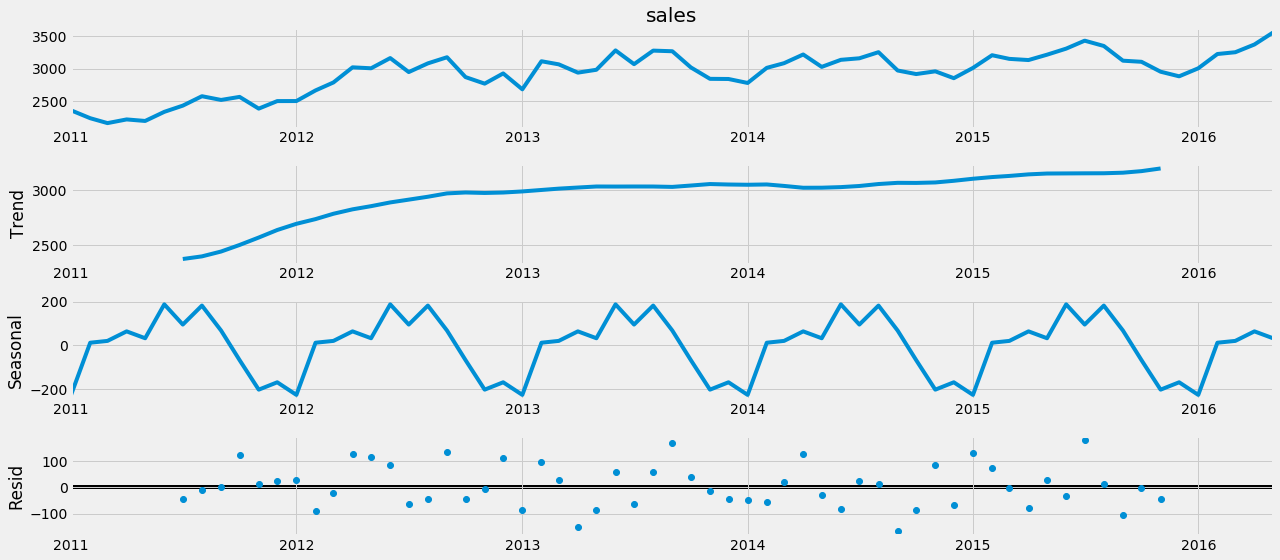

In [53]:
decompose(y_TX1)

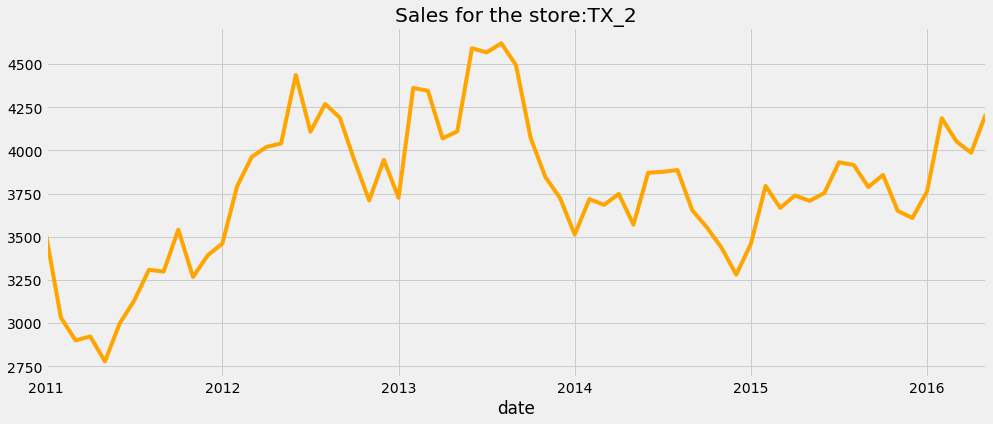

In [54]:
TX_2 = sales("store_id","TX_2")
y_TX2 = TX_2['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_TX2.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:TX_2"))
plt.show()

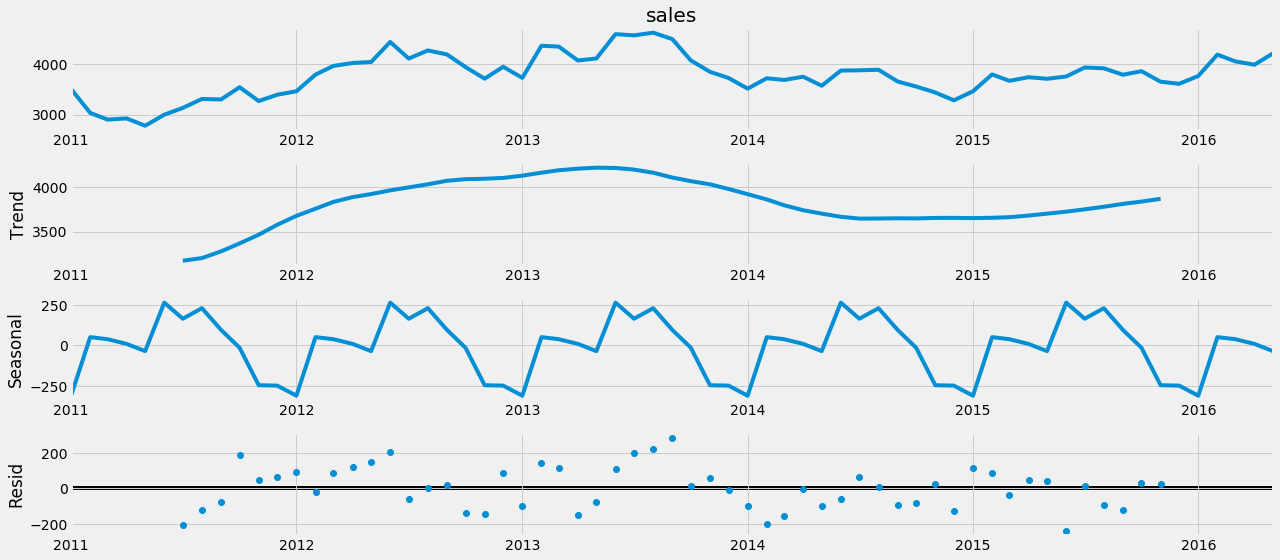

In [55]:
decompose(y_TX2)

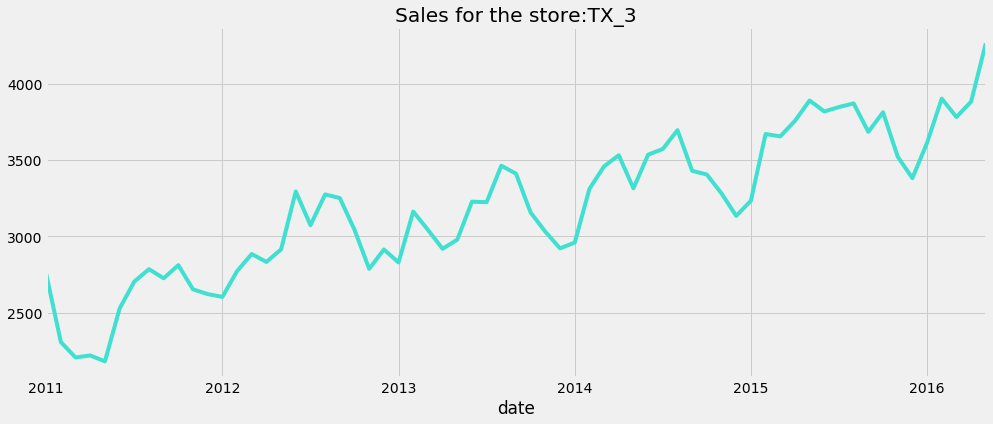

In [56]:
TX_3 = sales("store_id","TX_3")
y_TX3 = TX_3['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_TX3.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:TX_3"))
plt.show()

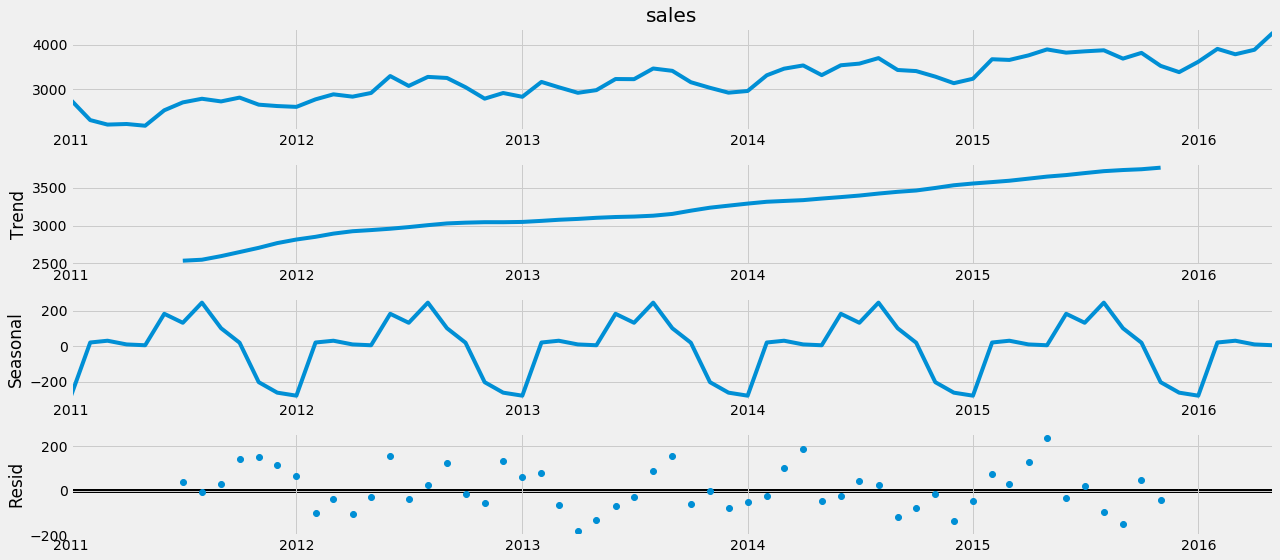

In [57]:
decompose(y_TX3)

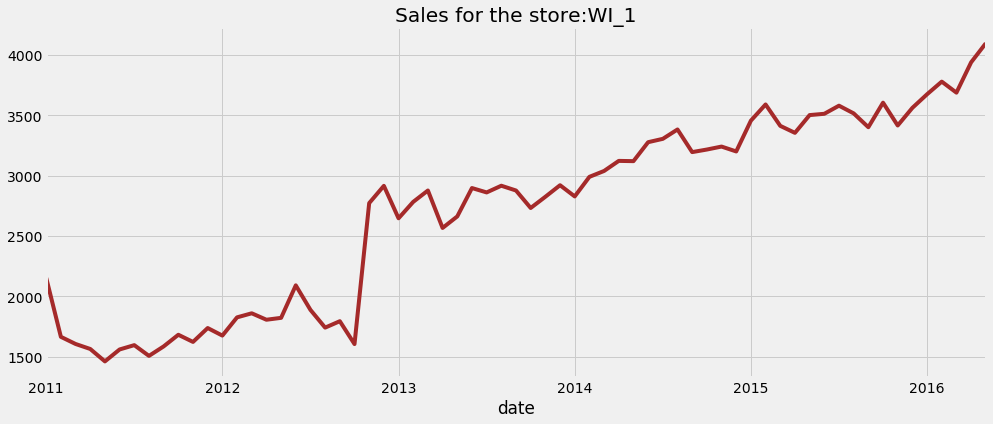

In [58]:
WI_1 = sales("store_id","WI_1")
y_WI1 = WI_1['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_WI1.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:WI_1"))
plt.show()

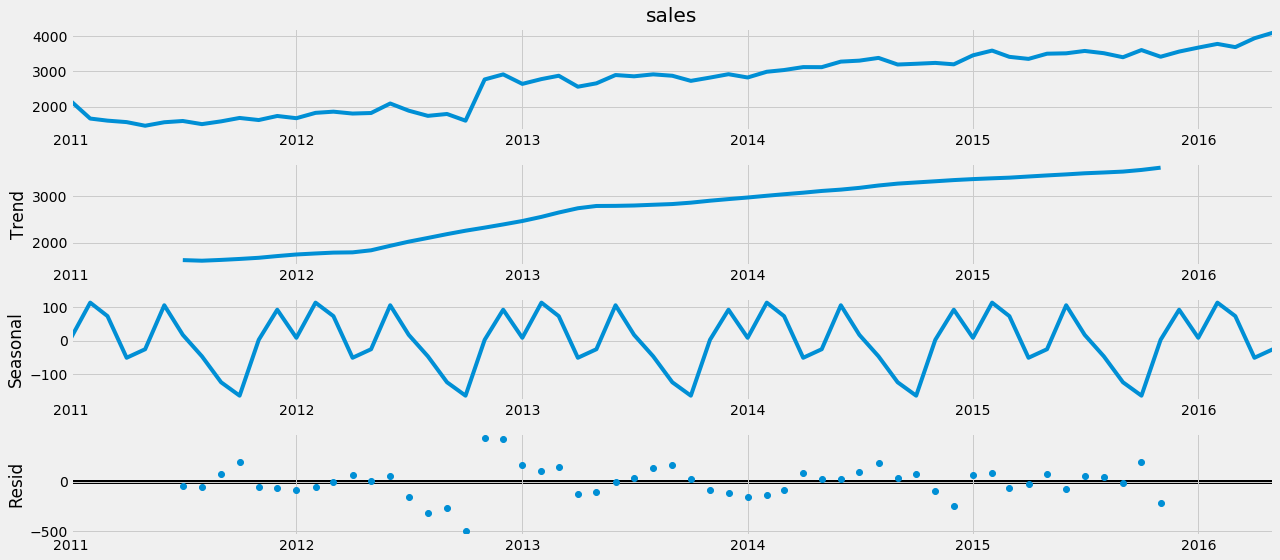

In [59]:
decompose(y_WI1)

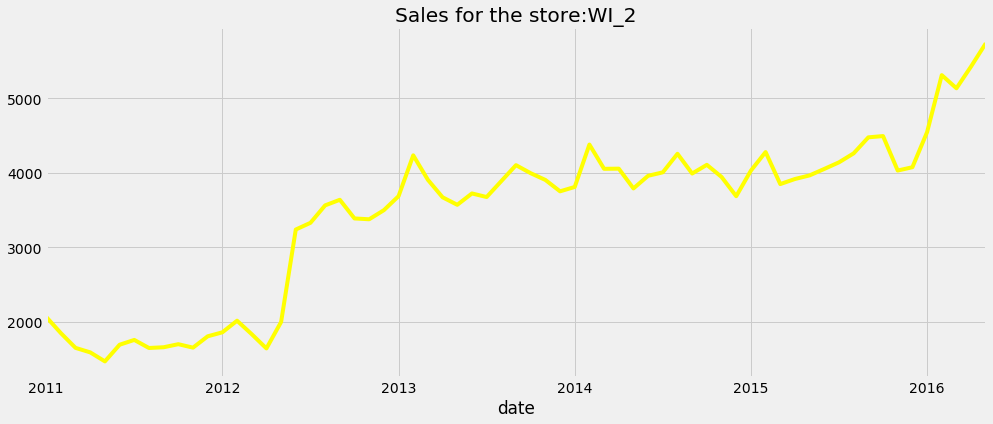

In [60]:
WI_2= sales("store_id","WI_2")
y_WI2 = WI_2['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_WI2.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:WI_2"))
plt.show()

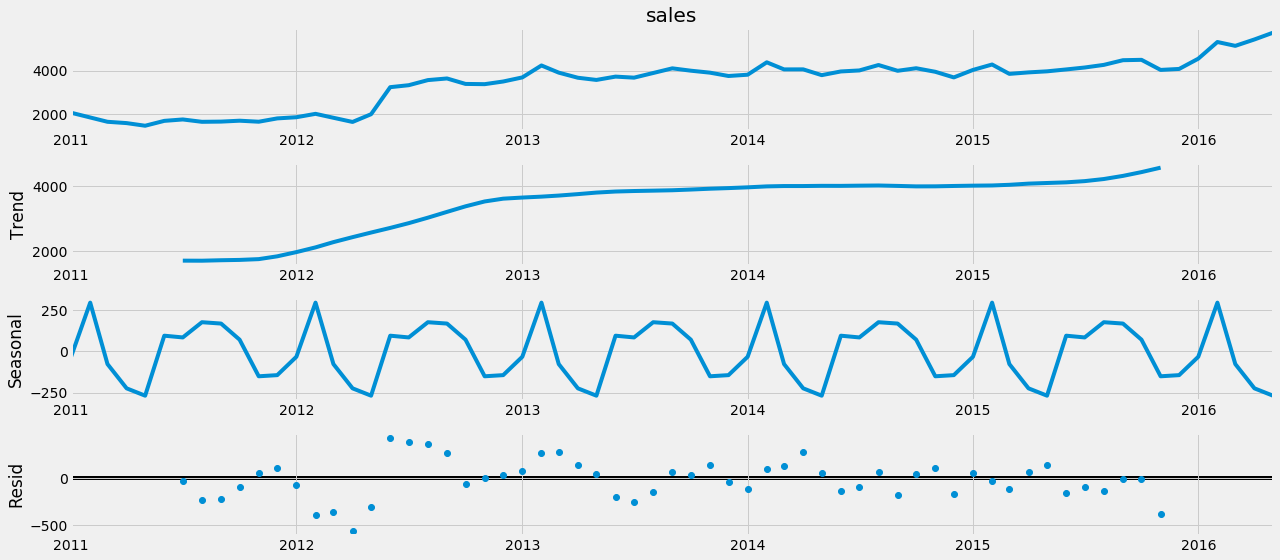

In [61]:
decompose(y_WI2)

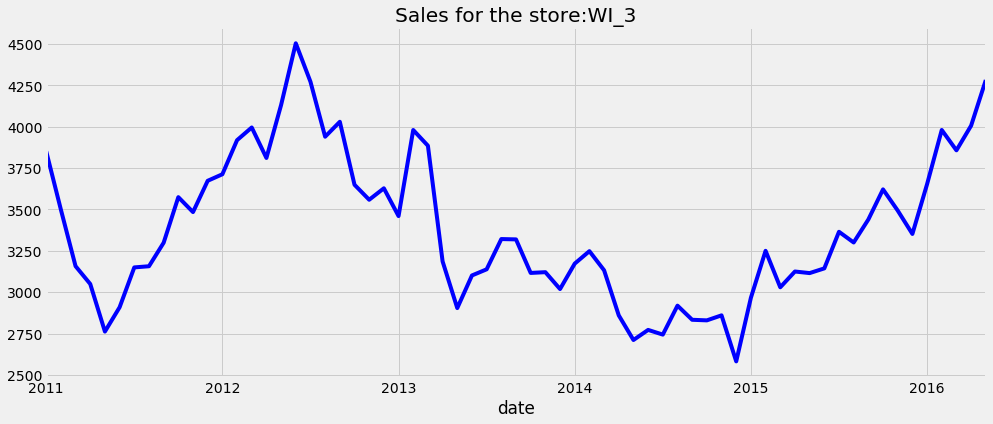

In [62]:
WI_3= sales("store_id","WI_3")
y_WI3 = WI_3['sales'].resample('MS').mean()
colour = random_color()
plt.ylabel = ("Sales")
y_WI3.plot(figsize=(15, 6),color = colour,title = ("Sales for the store:WI_3"))
plt.show()

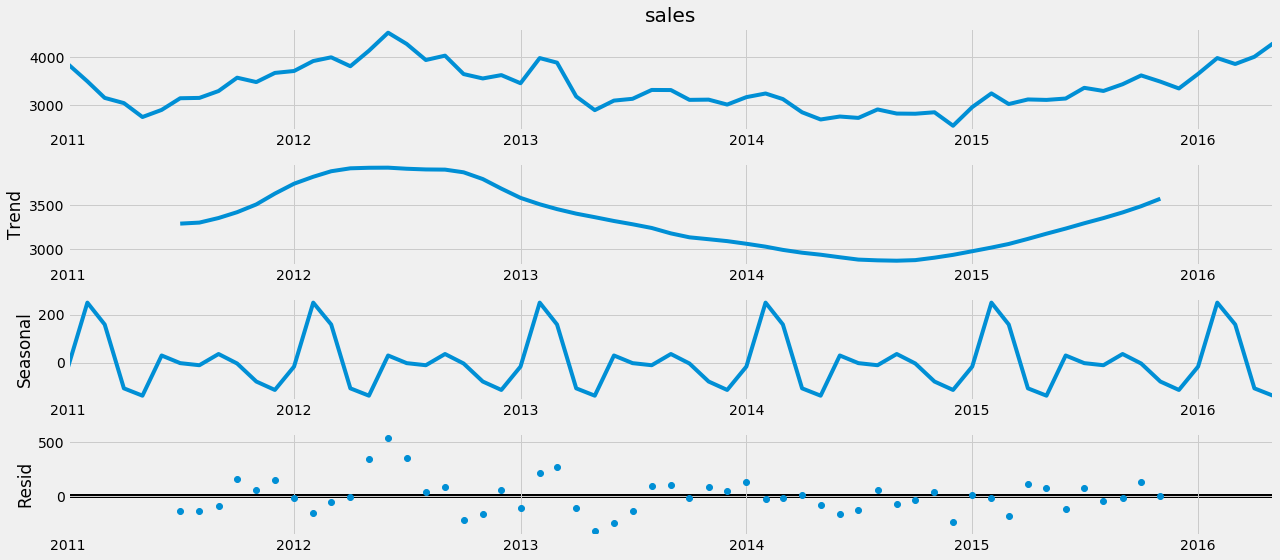

In [63]:
decompose(y_WI3)

In [64]:
del CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
gc.collect()

41039

# TOP SELLING PRODUCTS

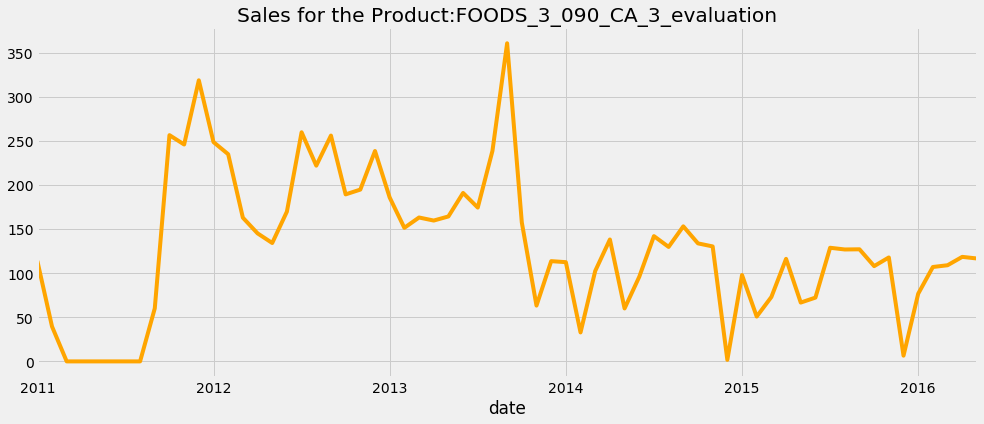

In [65]:
top = sales("id",top3[0])
y_top = top['sales'].resample('MS').mean()
colour = random_color()
y_top.plot(figsize=(15, 6),color = colour,title = ("Sales for the Product:" + top3[0]))
plt.show()

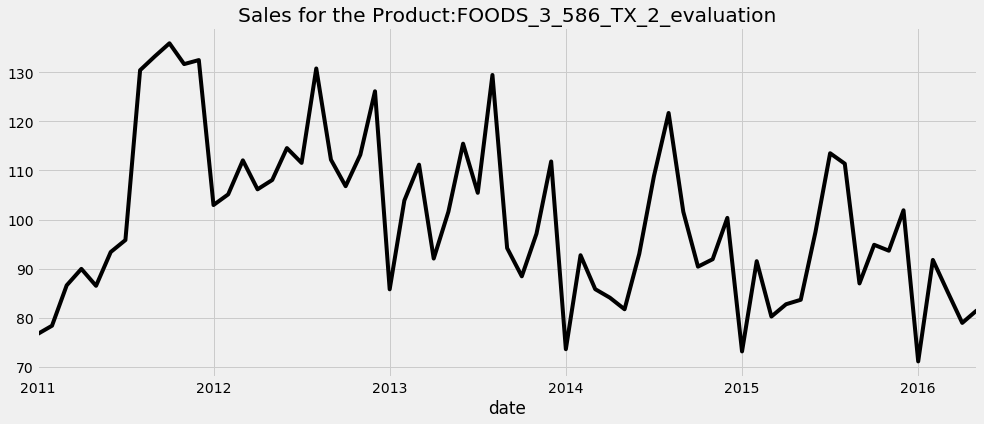

In [66]:
top = sales("id",top3[1])
y_top = top['sales'].resample('MS').mean()
colour = random_color()
y_top.plot(figsize=(15, 6),color = colour,title = ("Sales for the Product:" + top3[1]))
plt.show()

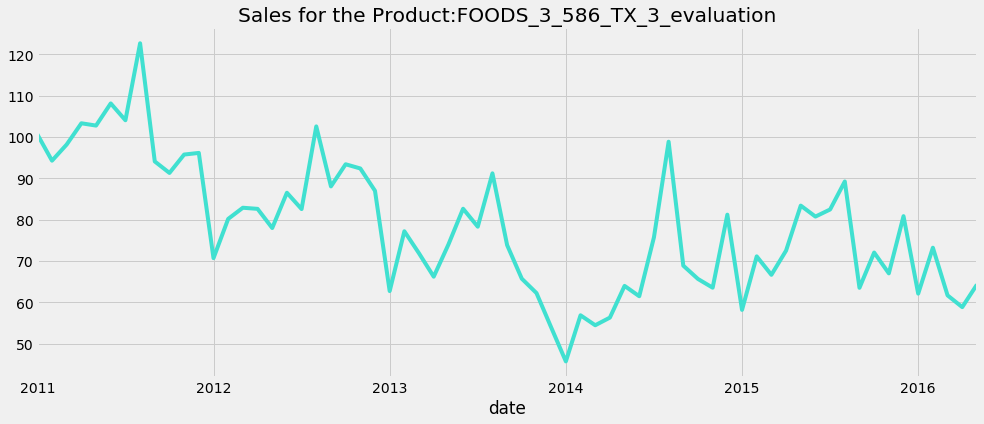

In [67]:
top = sales("id",top3[2])
y_top = top['sales'].resample('MS').mean()
colour = random_color()
y_top.plot(figsize=(15, 6),color = colour,title = ("Sales for the Product:" + top3[2]))
plt.show()

In [68]:
del top3,y_top
gc.collect()

9514

# PRICE DISTRIBUTION

Text(0.5, 1.0, 'Price Distribution')

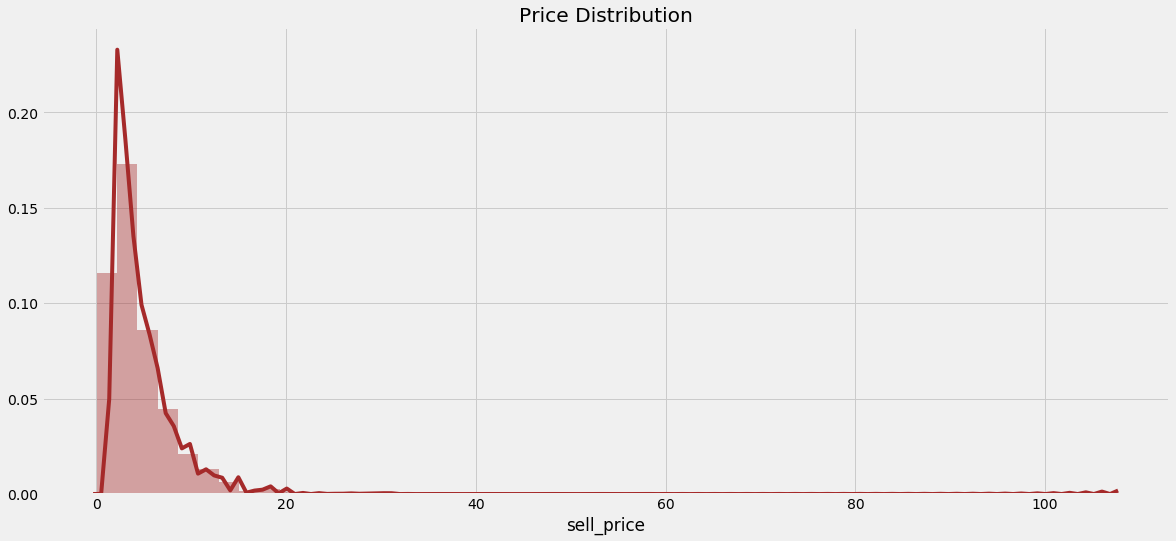

In [69]:
colour = random_color()
sns.distplot(sell_prices["sell_price"],color = colour).set_title("Price Distribution")

Text(0.5, 1.0, 'Price Distribution for CA_1')

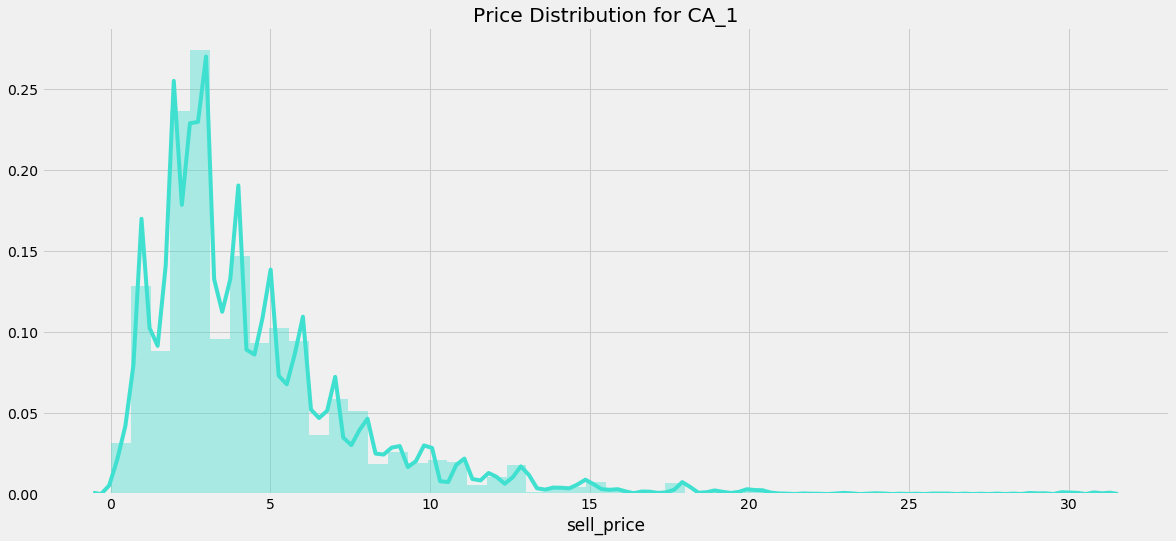

In [70]:
colour = random_color()
CA_1= sell_prices[sell_prices["store_id"] == "CA_1"]
sns.distplot(CA_1["sell_price"],color = colour).set_title("Price Distribution for CA_1")

Text(0.5, 1.0, 'Price Distribution for CA_2')

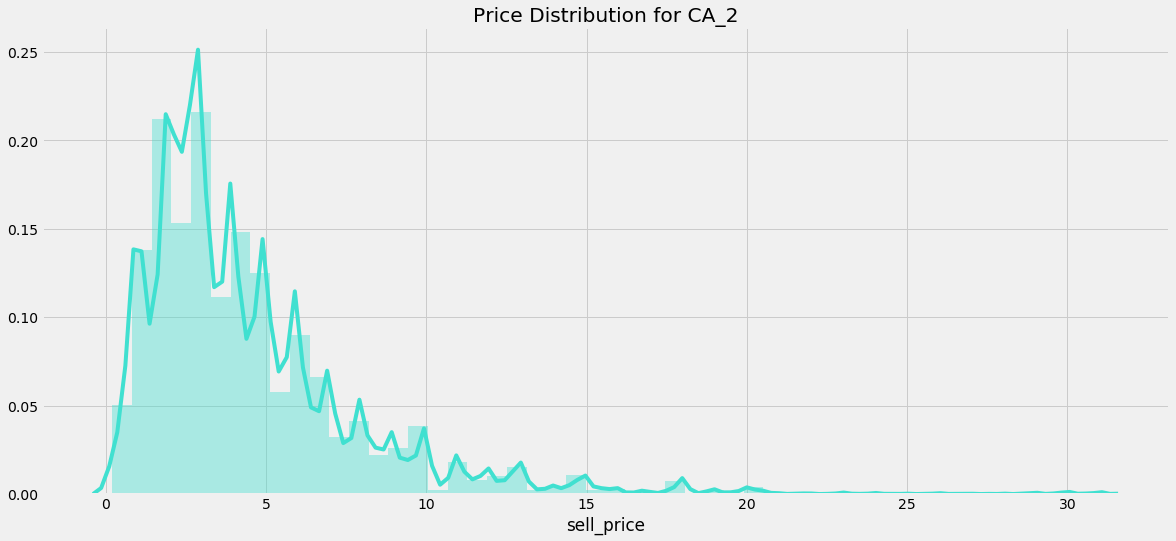

In [71]:
colour = random_color()
CA_2= sell_prices[sell_prices["store_id"] == "CA_2"]
sns.distplot(CA_2["sell_price"],color = colour).set_title("Price Distribution for CA_2")

Text(0.5, 1.0, 'Price Distribution for CA_3')

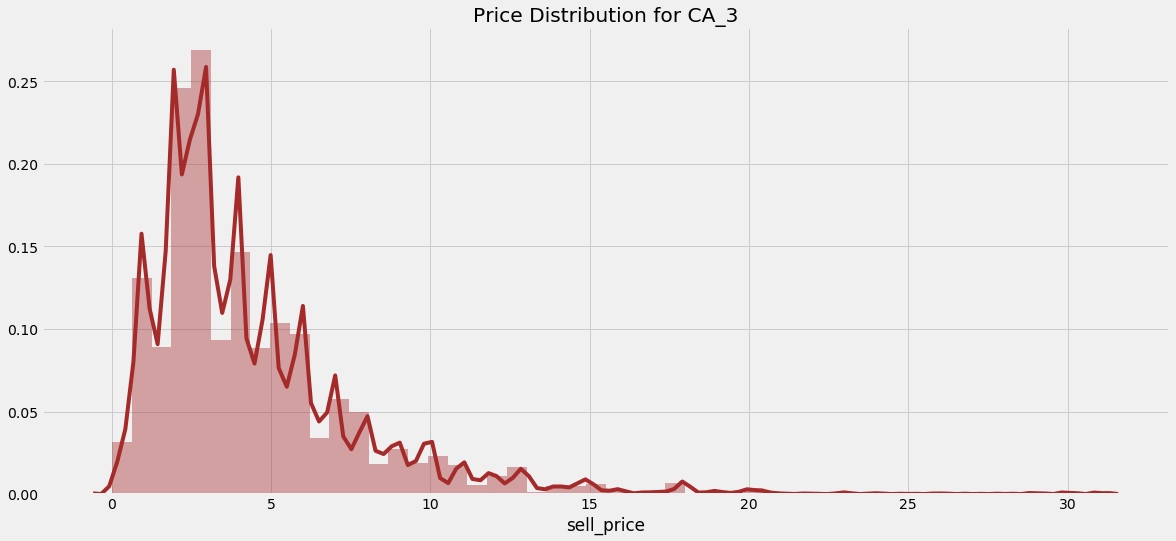

In [72]:
colour = random_color()
CA_3= sell_prices[sell_prices["store_id"] == "CA_3"]
sns.distplot(CA_3["sell_price"],color = colour).set_title("Price Distribution for CA_3")

Text(0.5, 1.0, 'Price Distribution for CA_4')

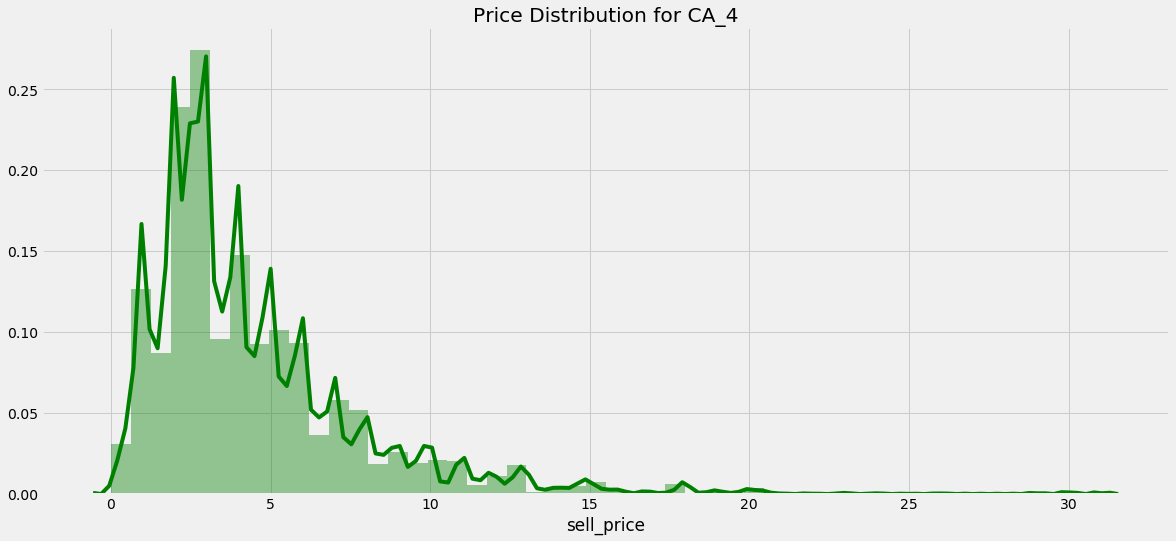

In [73]:
colour = random_color()
CA_4= sell_prices[sell_prices["store_id"] == "CA_4"]
sns.distplot(CA_4["sell_price"],color = colour).set_title("Price Distribution for CA_4")

Text(0.5, 1.0, 'Price Distribution for TX_1')

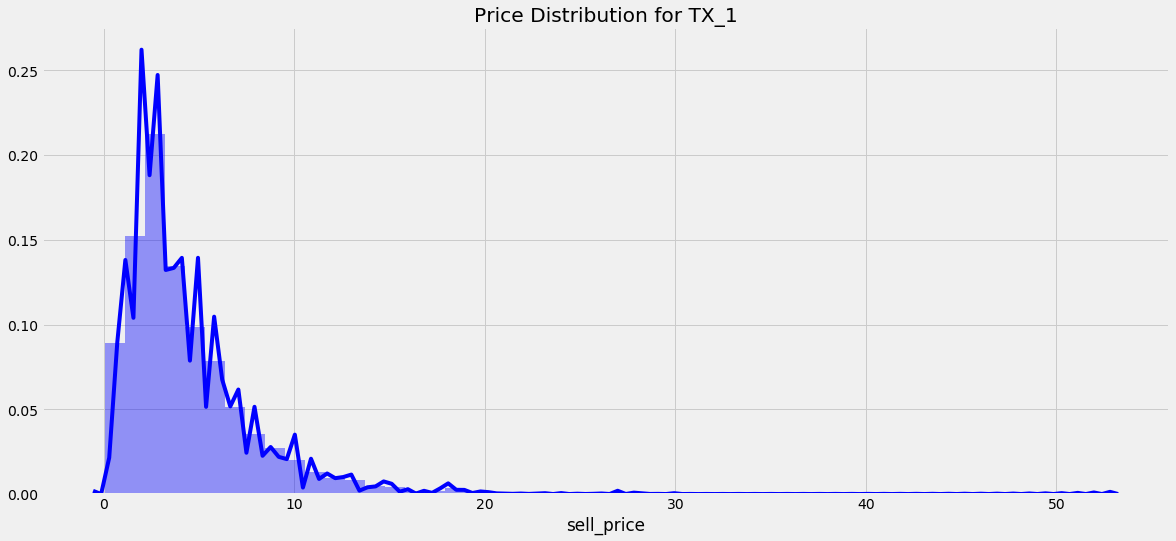

In [74]:
colour = random_color()
TX_1= sell_prices[sell_prices["store_id"] == "TX_1"]
sns.distplot(TX_1["sell_price"],color = colour).set_title("Price Distribution for TX_1")

Text(0.5, 1.0, 'Price Distribution for TX_2')

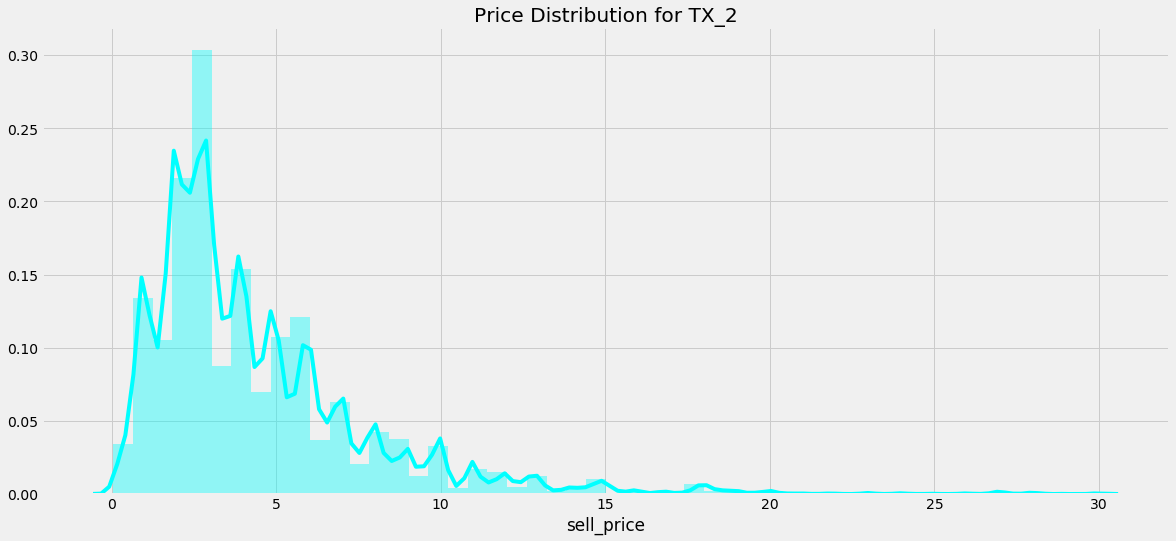

In [75]:
colour = random_color()
TX_2= sell_prices[sell_prices["store_id"] == "TX_2"]
sns.distplot(TX_2["sell_price"],color = colour).set_title("Price Distribution for TX_2")

Text(0.5, 1.0, 'Price Distribution for TX_3')

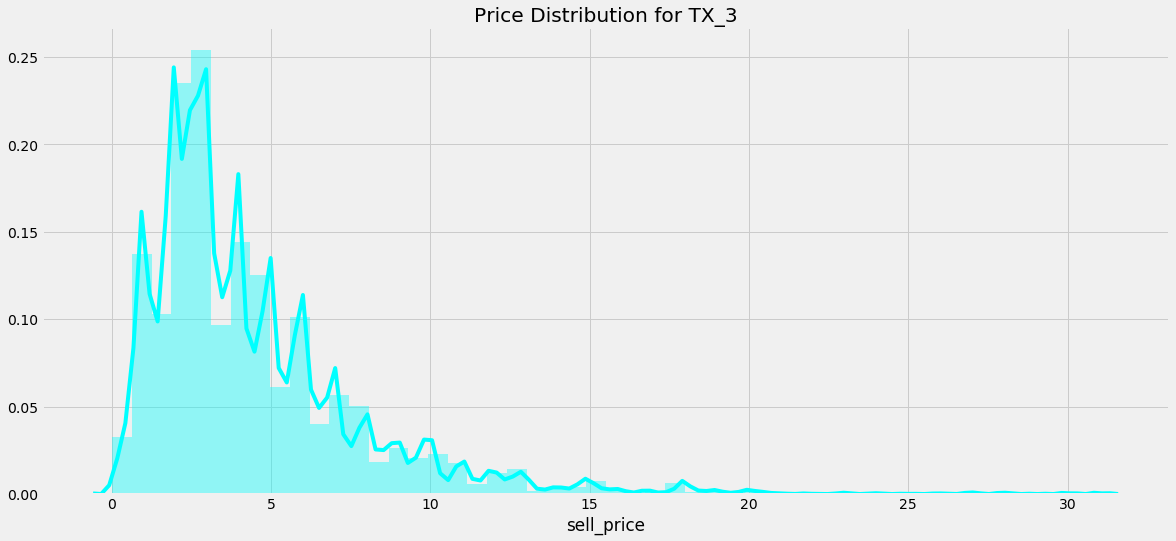

In [76]:
colour = random_color()
TX_3= sell_prices[sell_prices["store_id"] == "TX_3"]
sns.distplot(TX_3["sell_price"],color = colour).set_title("Price Distribution for TX_3")

Text(0.5, 1.0, 'Price Distribution for WI_1')

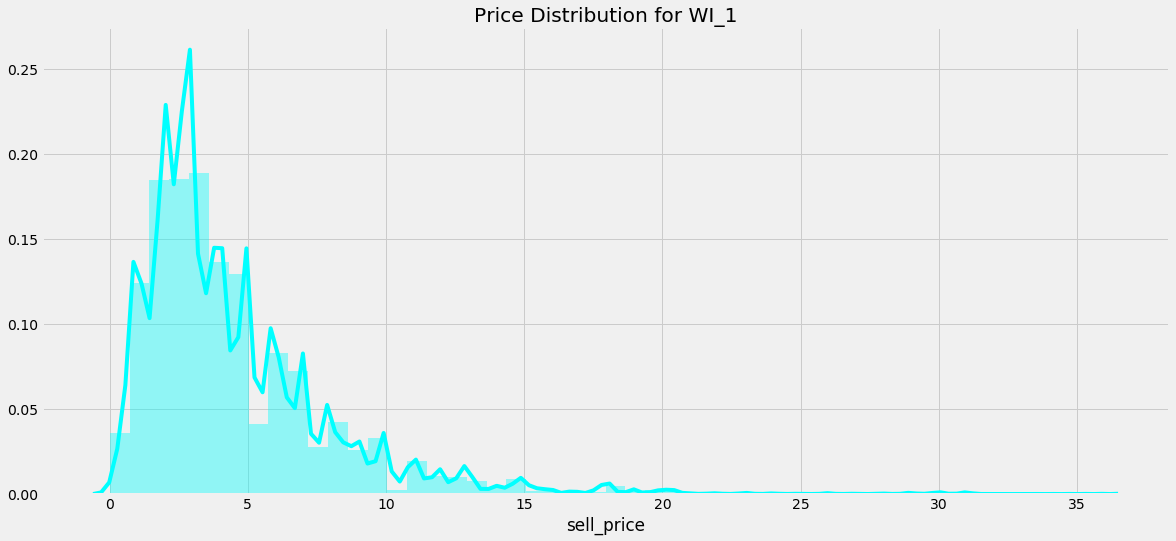

In [77]:
colour = random_color()
WI_1= sell_prices[sell_prices["store_id"] == "WI_1"]
sns.distplot(WI_1["sell_price"],color = colour).set_title("Price Distribution for WI_1")

Text(0.5, 1.0, 'Price Distribution for WI_2')

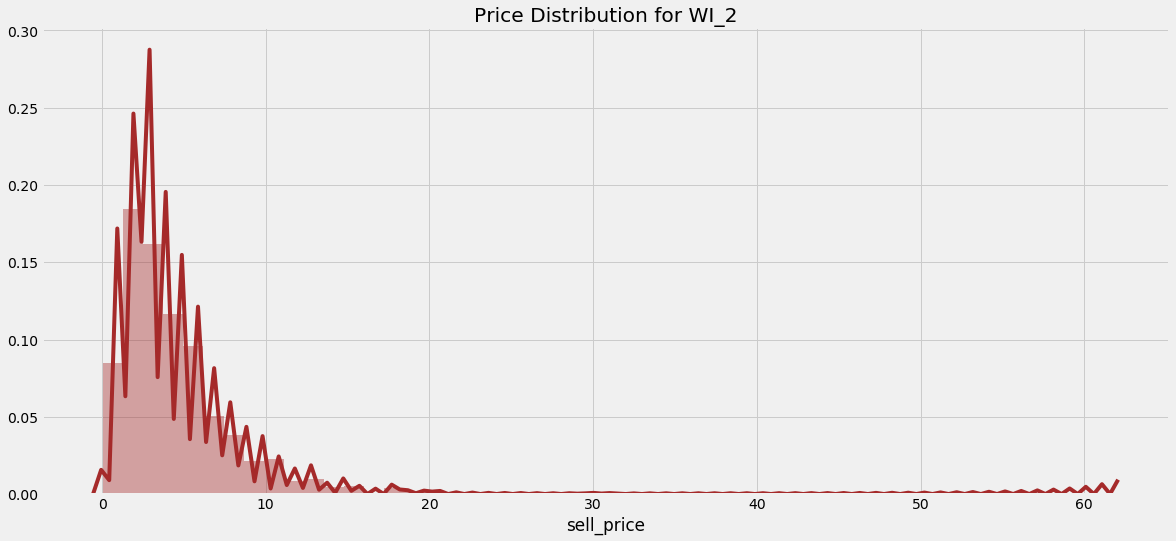

In [78]:
colour = random_color()
WI_2= sell_prices[sell_prices["store_id"] == "WI_2"]
sns.distplot(WI_2["sell_price"],color = colour).set_title("Price Distribution for WI_2")

Text(0.5, 1.0, 'Price Distribution for WI_3')

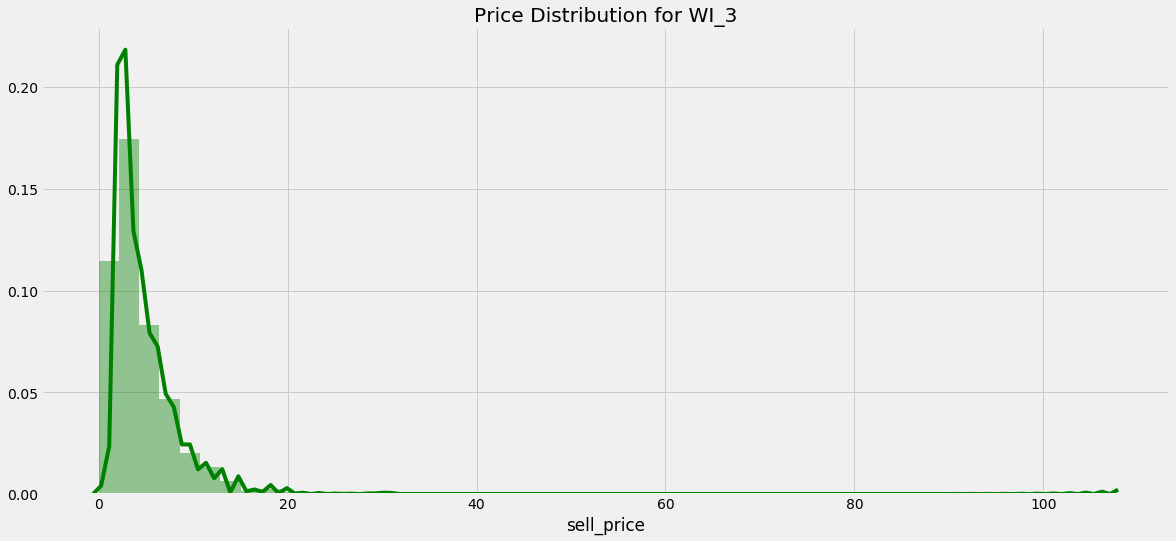

In [79]:
colour = random_color()
WI_3= sell_prices[sell_prices["store_id"] == "WI_3"]
sns.distplot(WI_3["sell_price"],color = colour).set_title("Price Distribution for WI_3")

In [80]:
del sell_prices,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
gc.collect()

20

In [81]:
import gc
gc.collect()

20

Link to model building notebook: https://www.kaggle.com/jagdmir/m5-forecasting-part-two-lgbm-regressor